In [1]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore
from sklearn.metrics import mean_squared_error # type: ignore

# Start

In [2]:
import glob

folder_path = 'LJP'

# Get a list of all CSV files in the folder
csv_files = glob.glob(folder_path + '/*.csv')

# Create an empty list to store the DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
	df = pd.read_csv(file)
	dfs.append(df)

# Concatenate all the DataFrames together
df_arso = pd.concat(dfs, ignore_index=True)
df_arso.head()

,station id,station name,valid,T [°C],količina padavin [mm],globalno sev. [W/m2]
0,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:00,-2.6,0.0,0.0
1,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:10,-2.6,NaN,NaN
2,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:20,-2.6,NaN,NaN
3,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:30,-3.4,0.0,0.0
4,_3047,Letališče Jožeta Pučnika Ljubljana,2022-01-01 00:40,-2.9,NaN,NaN


In [3]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_arso):
	# Filter rows based on column: ' valid'
	df_arso = df_arso[df_arso[' valid'].str.endswith("00", na=False)]
	# Drop columns: 'station id', ' station name'
	df_arso = df_arso.drop(columns=['station id', ' station name'])
	# Change column type to datetime64[ns] for column: ' valid'
	df_arso = df_arso.astype({' valid': 'datetime64[ns]'})
	# Rename column ' valid' to 'datum'
	df_arso = df_arso.rename(columns={' valid': 'datum'})
	return df_arso

df_arso_clean = clean_data(df_arso.copy())
df_arso_clean.head()

,datum,T [°C],količina padavin [mm],globalno sev. [W/m2]
0,2022-01-01 00:00:00,-2.6,0.0,0.0
6,2022-01-01 01:00:00,-3.2,0.0,0.0
12,2022-01-01 02:00:00,-3.9,0.0,0.0
18,2022-01-01 03:00:00,-2.8,0.0,0.0
24,2022-01-01 04:00:00,-3.1,0.0,0.0


In [4]:
df_eles = pd.read_csv('ELES.csv', sep=';')

"""
Cell generated by Data Wrangler.
"""
from datetime import datetime

def clean_data(df_eles):
    df_eles['datum'] = pd.to_datetime(df_eles['datum'], dayfirst=True)
    df_eles['ura'] = df_eles['ura'].str[1:3].astype(int) - 1
    df_eles['datum'] = df_eles['datum'] + pd.to_timedelta(df_eles['ura'], unit='h')
    df_eles.drop(columns=['ura', 'predvidena_proizvodnja', 'dejanska_proizvodnja', 'nek', 'termo', 'hidro', 'predviden_prevzem'], inplace=True)
    # Filter rows based on column: 'datum'
    # df_eles = df_eles[df_eles['datum'] >= datetime.strptime('2024-08-01T00:00:00.000Z', '%Y-%m-%dT%H:%M:%S.%fZ')]
    return df_eles

df_eles_clean = clean_data(df_eles.copy())
df_eles_clean.head()

,datum,dejanski_prevzem
0,2022-01-01 00:00:00,1044.0
1,2022-01-01 01:00:00,1018.0
2,2022-01-01 02:00:00,975.0
3,2022-01-01 03:00:00,944.0
4,2022-01-01 04:00:00,936.0


In [5]:
df_pokritost = pd.read_csv('LJP_pokritost_2022-2024.csv')
df_pokritost['datum'] = pd.to_datetime(df_pokritost[' valid'])
df_pokritost = df_pokritost.drop(columns=['station id', ' station name', ' valid'])
df_pokritost.head()

,oblačnost [%],datum
0,37.0,2022-01-01
1,40.0,2022-01-02
2,80.0,2022-01-03
3,100.0,2022-01-04
4,100.0,2022-01-05


In [6]:
df_prazniki = pd.read_csv('prazniki.csv', header=None)
df_prazniki['datum'] = pd.to_datetime(df_prazniki[0])
df_prazniki = df_prazniki.drop(columns=[0])
df_prazniki = df_prazniki.rename(columns={1: 'holiday'})

# Generate a new DataFrame with all dates between 2022-01-01 and 2024-10-23
df_all_dates = pd.DataFrame({'datum': pd.date_range('2022-01-01', '2024-10-23')})

# Merge the new DataFrame with df_prazniki, filling in missing values with 0
df_prazniki = pd.merge(df_all_dates, df_prazniki, on='datum', how='left').fillna(0)

df_prazniki.head()

,datum,holiday
0,2022-01-01,1.0
1,2022-01-02,1.0
2,2022-01-03,0.0
3,2022-01-04,0.0
4,2022-01-05,0.0


In [7]:
df1 = pd.merge(df_eles_clean, df_arso_clean, on='datum')
df2 = pd.merge(df1, df_pokritost, on='datum', how='outer')
df = pd.merge(df2, df_prazniki, on='datum', how='outer')
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Drop duplicate rows in column: 'datum'
    df = df.drop_duplicates(subset=['datum'])
    # Renames
    df = df.rename(columns={'datum': 'date', 
                            'dejanski_prevzem': 'consumption',
                            'T [°C]': 'temperature',
                            'količina padavin [mm]': 'precipitation',
                            'globalno sev. [W/m2]': 'irradiation',
                            'oblačnost [%]': 'cloudiness'
                        })
    df.ffill(inplace=True)
    df = df[(df['date'].dt.day != 29) | (df['date'].dt.month != 2)]
    df = df.drop(df.index[0])
    return df

df = clean_data(df.copy())
df.head()

,date,consumption,temperature,precipitation,irradiation,cloudiness,holiday
1,2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,37.0,1.0
2,2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,37.0,1.0
3,2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,37.0,1.0
4,2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.0,1.0
5,2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,37.0,1.0


# Moja koda od tu naprej

Dodamo vse ostale stvari v model za train

In [8]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore

df_hourly = df.copy()
df_hourly['shifted_consumption_168'] = df_hourly['consumption'].shift(168)
df_hourly['shifted_consumption_48'] = df_hourly['consumption'].shift(48)
df_hourly['shifted_consumption_8760'] = df_hourly['consumption'].shift(8760)
df_hourly['hour'] = df_hourly['date'].dt.hour
df_hourly['weekDay'] = df_hourly['date'].dt.weekday

# Split the dataset based on the cutoff date
cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]

# LSTM

In [9]:
# Python
import pandas as pd
from prophet import Prophet

d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [10]:
df_hourly = df.copy()
df_hourly.rename(columns={'date': 'ds', 'consumption': 'y'}, inplace=True)
df_hourly.drop({'temperature', 'precipitation', 'irradiation', 'cloudiness', 'holiday'}, axis=1, inplace=True)
df_hourly.head()

,ds,y
1,2022-01-01 01:00:00,1018.0
2,2022-01-01 02:00:00,975.0
3,2022-01-01 03:00:00,944.0
4,2022-01-01 04:00:00,936.0
5,2022-01-01 05:00:00,952.0


In [11]:
# Python
m = Prophet()
m.fit(df_hourly)

03:11:36 - cmdstanpy - INFO - Chain [1] start processing
03:11:44 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Python
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
24980,2025-10-19 23:00:00
24981,2025-10-20 23:00:00
24982,2025-10-21 23:00:00
24983,2025-10-22 23:00:00
24984,2025-10-23 23:00:00


In [13]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
24980,2025-10-19 23:00:00,1296.818472,819.617080,1832.116763
24981,2025-10-20 23:00:00,1495.958993,1041.628492,2005.615470
24982,2025-10-21 23:00:00,1490.968806,1022.512997,1991.660718
24983,2025-10-22 23:00:00,1517.874578,1041.359835,2038.707375
24984,2025-10-23 23:00:00,1500.763791,1023.430100,2024.335375


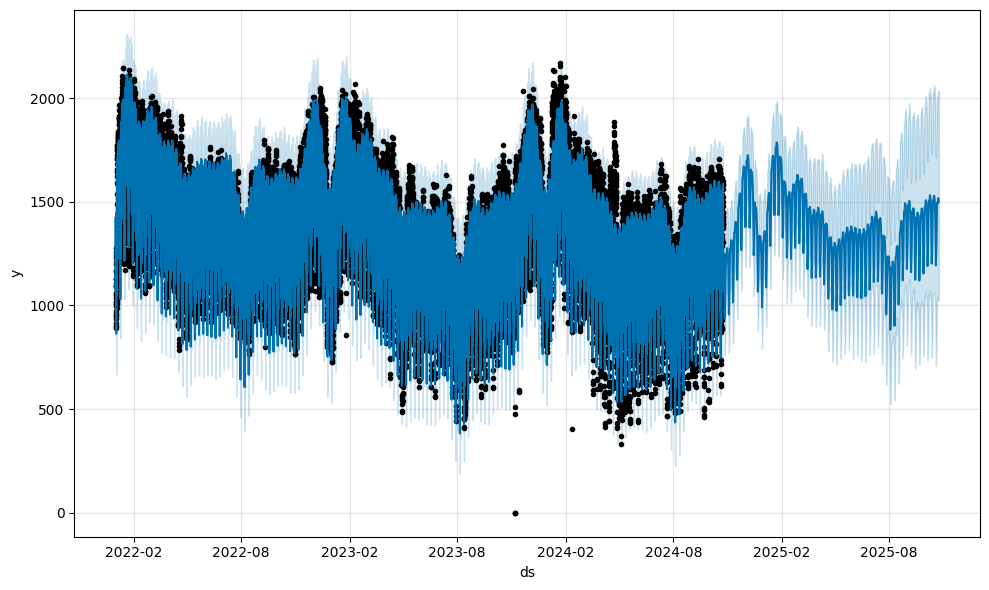

In [14]:
# Python
fig1 = m.plot(forecast)

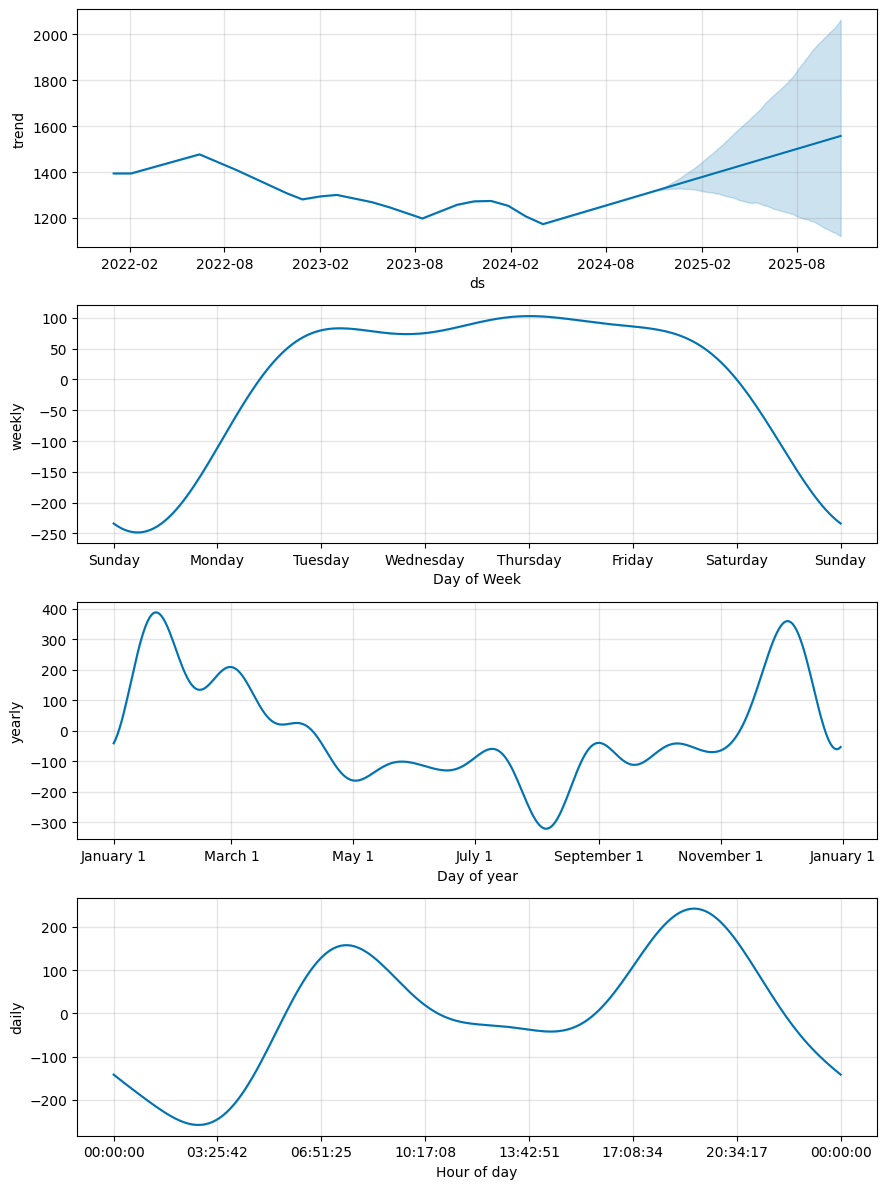

In [15]:
# Python
fig2 = m.plot_components(forecast)

In [ ]:
%pip install neuralprophet

In [19]:
from neuralprophet import NeuralProphet, set_log_level

In [21]:
m = NeuralProphet(
    n_changepoints=0,
    weekly_seasonality=True,
)
m.set_plotting_backend("plotly-static")
metrics = m.fit(df_hourly, freq="60min")
future = m.make_future_dataframe(df_hourly, periods=7 * 24, n_historic_predictions=True)
forecast = m.predict(future)
m.plot(forecast)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.98% of the data.
WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I 

Epoch 40: 100%|██████████| 40/40 [00:54<00:00,  0.73it/s]   


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 40


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (193) is too small than the required number                     for the learning rate finder (259). The results might not be optimal.
Finding best initial lr: 100%|██████████| 259/259 [00:02<00:00, 119.11it/s]


Training: |          | 0/? [01:01<?, ?it/s, v_num=2, train_loss=0.0116, reg_loss=0.000, MAE=133.0, RMSE=172.0, Loss=0.0117, RegLoss=0.000]

WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.98% of the data.
WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated 


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 164.39it/s]


AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.